k=0.1571, <X_k> = -1.7536419769718685
k=0.4712, <X_k> = -1.5319143824805166
k=0.7854, <X_k> = -1.0713311504464638
k=1.0996, <X_k> = -0.689210868489769
k=1.4137, <X_k> = -0.37143657024612564
k=1.7279, <X_k> = -0.05819410944552797
k=2.0420, <X_k> = 0.2683124624624705
k=2.3562, <X_k> = 0.6664841709856817
k=2.6704, <X_k> = 1.2167698745864326
k=2.9845, <X_k> = 1.8579316002169712
Sum of <X_k> = -1.4662309498287145


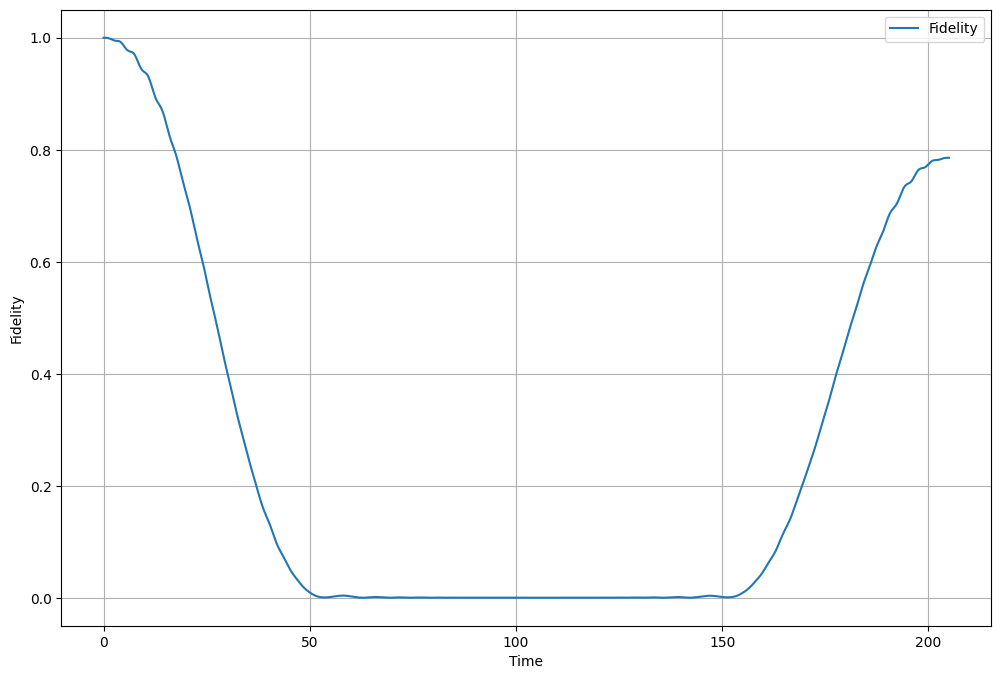

In [1]:
import numpy as np
import matplotlib.pyplot as plt

a = 1.0
ℏ = 1.0
N = 20
J = 1.0
g_1 = 1.0
g_2 = 0.2
λ_k = 0.001

T = 100
T_prime = 5
h = 0.01
t0 = 0
te = 2 * T + T_prime
T_F = T + T_prime/2.0
T_G_end = 2*T + T_prime

ψ0 = np.array([1, 0], dtype=complex)
ρ0 = np.outer(ψ0, ψ0.conj())

def make_Hamiltonian_per_k(T_A, T_B, a, k):
    Driver_Hamiltonian = -2 * T_A * g_1 * (np.identity(2)-np.array([[0, 0], [0, 1]]))
    Problem_Hamiltonian = 2 * T_B * (J*(-np.cos(k * a) * np.array([[0, 0], [0, 1]]) 
                                        + np.sin(k * a) * np.array([[0, 1], [1, 0]])) 
                                    + g_2 * (np.identity(2)-np.array([[0, 0], [0, 1]])))
    return Driver_Hamiltonian + Problem_Hamiltonian

def get_k_values(N, a):
    n_values = range(N // 2)
    k_values_positive = []
    for n in n_values:
        k_value = (2 * np.pi / (N * a)) * (n + 0.5)
        k_values_positive.append(k_value)
    k_values = np.array(k_values_positive) 
    return k_values

def A_EMQA(t):
    A_t = np.zeros_like(t)
    cond1 = (t >= 0) & (t <= T)
    cond2 = (t > T) & (t <= T + T_prime)
    cond3 = (t > T + T_prime) & (t <= 2 * T + T_prime)
    A_t[cond1] = - (t[cond1] / T) + 1
    A_t[cond2] = 0
    A_t[cond3] = - (t[cond3] / T) + (T_prime / T) + 1
    return A_t

def B_EMQA(t):
    B_t = np.zeros_like(t)
    cond1 = (t >= 0) & (t <= T)
    cond2 = (t > T) & (t <= T + T_prime)
    cond3 = (t > T + T_prime) & (t <= 2 * T + T_prime)
    B_t[cond1] = t[cond1] / T
    B_t[cond2] = - (2 * t[cond2] / T_prime) + (2 * T / T_prime) + 1
    B_t[cond3] = (t[cond3] / T) - (T_prime / T) - 2
    return B_t

def rungekutta_first_order(f, t0, x0, te, h):
    ts = np.arange(t0, te + h, h)
    xs = []
    x = x0.copy()
    for t in ts:
        xs.append(x)
        k1 = h * f(t, x)
        k2 = h * f(t + h / 2, x + k1 / 2)
        k3 = h * f(t + h / 2, x + k2 / 2)
        k4 = h * f(t + h, x + k3)
        x = x + (k1 + 2 * k2 + 2 * k3 + k4) / 6
    return ts, np.array(xs)

def f_Lindblad_equation(t, ρ, k):
    T_A = A_EMQA(np.array([t]))[0]
    T_B = B_EMQA(np.array([t]))[0]
    H_k = make_Hamiltonian_per_k(T_A, T_B, a, k)
    L = np.array([[0, 0], [0, 1]], dtype=complex)
    first = -1j * (H_k @ ρ - ρ @ H_k) / ℏ
    second = (λ_k / 2) * (2 * L @ ρ @ L.conj().T - L.conj().T @ L @ ρ - ρ @ L.conj().T @ L)
    return first + second

def f_Lindblad_for_fixed_k(k):
    def f_fixed(t, ρ):
        return f_Lindblad_equation(t, ρ, k)
    return f_fixed

def evolve_rho(rho_initial, k, t_start, t_end, h):
    f_fixed_k = f_Lindblad_for_fixed_k(k)
    _, rhos = rungekutta_first_order(f_fixed_k, t_start, rho_initial, t_end, h)
    # 最終状態
    return rhos[-1]  


def fidelity_with_init(rho):
    # <psi_init|rho|psi_init>
    return np.real(np.vdot(ψ0, rho @ ψ0))  

# 射影演算子
# = (I + X_k)/2
P_X_plus = np.array([[1,0],[0,0]], dtype=complex)  
# = (I - X_k)/2
P_X_minus = np.array([[0,0],[0,1]], dtype=complex) 

# k 値を取得
k_values = get_k_values(N, a)

# F後状態, G後状態の計算
rho_F = {}
for k in k_values:
    rho_F[k] = evolve_rho(ρ0, k, 0, T_F, h)

rho_final = {}
for k in k_values:
    rho_final[k] = evolve_rho(rho_F[k], k, T_F, te, h)

# P_0_pm を k毎に計算
P_0_pm_dict = {}
for k in k_values:
    P_0_pm_dict[k] = fidelity_with_init(rho_final[k])

P_Xk_plus = {}
P_Xk_minus = {}

for k in k_values:
    rho_Fk = rho_F[k]
    # 射影適用
    rho_Fk_plus = P_X_plus @ rho_Fk @ P_X_plus
    rho_Fk_minus = P_X_minus @ rho_Fk @ P_X_minus
    # G適用
    rho_final_plus = evolve_rho(rho_Fk_plus, k, T_F, te, h)
    rho_final_minus = evolve_rho(rho_Fk_minus, k, T_F, te, h)
    # フィデリティ
    P_Xk_plus[k] = fidelity_with_init(rho_final_plus)
    P_Xk_minus[k] = fidelity_with_init(rho_final_minus)

# <X_k>計算
X_k_values_dict = {}
for k in k_values:
    if P_0_pm_dict[k] != 0:
        X_k_values_dict[k] = 2 * (P_Xk_plus[k] - P_Xk_minus[k]) / P_0_pm_dict[k]
    else:
        X_k_values_dict[k] = np.nan

# 結果表示
for k in k_values:
    print(f"k={k:.4f}, <X_k> = {X_k_values_dict[k]}")

sum_Xk = np.nansum(list(X_k_values_dict.values()))
print("Sum of <X_k> =", sum_Xk)


ts_full = np.arange(t0, te + h, h)

# 各kに対する現在の状態(初期化)
rho_current_k = {k: ρ0.copy() for k in k_values}

fidelity_product = []

for t in ts_full:
    # 全kについて1ステップ進行
    for k in k_values:
        k1 = h * f_Lindblad_equation(t, rho_current_k[k], k)
        k2 = h * f_Lindblad_equation(t + h/2, rho_current_k[k] + k1/2, k)
        k3 = h * f_Lindblad_equation(t + h/2, rho_current_k[k] + k2/2, k)
        k4 = h * f_Lindblad_equation(t + h, rho_current_k[k] + k3, k)
        rho_current_k[k] = rho_current_k[k] + (k1 + 2*k2 + 2*k3 + k4)/6

    # 全てのkに対してフィデリティを計算し積をとる
    fidelity_k_list = [fidelity_with_init(rho_current_k[k]) for k in k_values]
    fidelity_product.append(np.prod(fidelity_k_list))

# プロット
plt.figure(figsize=(12,8))
plt.plot(ts_full, fidelity_product, label='Fidelity')
plt.xlabel('Time')
plt.ylabel('Fidelity')
plt.grid(True)
plt.legend()
plt.show()

k=0.1571, <X_k> = -1.8714711448322734
k=0.4712, <X_k> = -1.5343799526254471
k=0.7854, <X_k> = -1.0735671813606702
k=1.0996, <X_k> = -0.6798968733900842
k=1.4137, <X_k> = -0.3633509706527227
k=1.7279, <X_k> = -0.04877326082621993
k=2.0420, <X_k> = 0.2753782675937743
k=2.3562, <X_k> = 0.6797376943345326
k=2.6704, <X_k> = 1.2093538162508786
k=2.9845, <X_k> = 1.8581009972039226
Sum of <X_k> = -1.5488686083043095


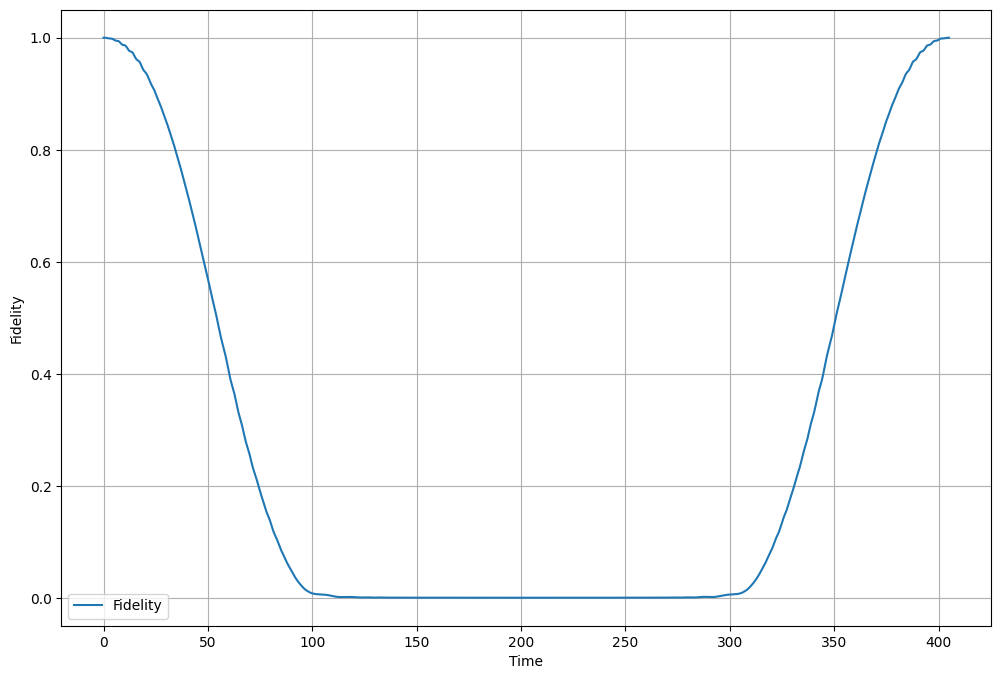

In [2]:
import numpy as np
import matplotlib.pyplot as plt

a = 1.0
ℏ = 1.0
N = 20
J = 1.0
g_1 = 1.0
g_2 = 0.2
λ_k = 0

T = 200
T_prime = 5
h = 0.01
t0 = 0
te = 2 * T + T_prime
T_F = T + T_prime/2.0
T_G_end = 2*T + T_prime

ψ0 = np.array([1, 0], dtype=complex)
ρ0 = np.outer(ψ0, ψ0.conj())

def make_Hamiltonian_per_k(T_A, T_B, a, k):
    Driver_Hamiltonian = -2 * T_A * g_1 * (np.identity(2)-np.array([[0, 0], [0, 1]]))
    Problem_Hamiltonian = 2 * T_B * (J*(-np.cos(k * a) * np.array([[0, 0], [0, 1]]) 
                                        + np.sin(k * a) * np.array([[0, 1], [1, 0]])) 
                                    + g_2 * (np.identity(2)-np.array([[0, 0], [0, 1]])))
    return Driver_Hamiltonian + Problem_Hamiltonian

def get_k_values(N, a):
    n_values = range(N // 2)
    k_values_positive = []
    for n in n_values:
        k_value = (2 * np.pi / (N * a)) * (n + 0.5)
        k_values_positive.append(k_value)
    k_values = np.array(k_values_positive) 
    return k_values

def A_EMQA(t):
    A_t = np.zeros_like(t)
    cond1 = (t >= 0) & (t <= T)
    cond2 = (t > T) & (t <= T + T_prime)
    cond3 = (t > T + T_prime) & (t <= 2 * T + T_prime)
    A_t[cond1] = - (t[cond1] / T) + 1
    A_t[cond2] = 0
    A_t[cond3] = - (t[cond3] / T) + (T_prime / T) + 1
    return A_t

def B_EMQA(t):
    B_t = np.zeros_like(t)
    cond1 = (t >= 0) & (t <= T)
    cond2 = (t > T) & (t <= T + T_prime)
    cond3 = (t > T + T_prime) & (t <= 2 * T + T_prime)
    B_t[cond1] = t[cond1] / T
    B_t[cond2] = - (2 * t[cond2] / T_prime) + (2 * T / T_prime) + 1
    B_t[cond3] = (t[cond3] / T) - (T_prime / T) - 2
    return B_t

def rungekutta_first_order(f, t0, x0, te, h):
    ts = np.arange(t0, te + h, h)
    xs = []
    x = x0.copy()
    for t in ts:
        xs.append(x)
        k1 = h * f(t, x)
        k2 = h * f(t + h / 2, x + k1 / 2)
        k3 = h * f(t + h / 2, x + k2 / 2)
        k4 = h * f(t + h, x + k3)
        x = x + (k1 + 2 * k2 + 2 * k3 + k4) / 6
    return ts, np.array(xs)

def f_Lindblad_equation(t, ρ, k):
    T_A = A_EMQA(np.array([t]))[0]
    T_B = B_EMQA(np.array([t]))[0]
    H_k = make_Hamiltonian_per_k(T_A, T_B, a, k)
    L = np.array([[0, 0], [0, 1]], dtype=complex)
    first = -1j * (H_k @ ρ - ρ @ H_k) / ℏ
    second = (λ_k / 2) * (2 * L @ ρ @ L.conj().T - L.conj().T @ L @ ρ - ρ @ L.conj().T @ L)
    return first + second

def f_Lindblad_for_fixed_k(k):
    def f_fixed(t, ρ):
        return f_Lindblad_equation(t, ρ, k)
    return f_fixed

def evolve_rho(rho_initial, k, t_start, t_end, h):
    f_fixed_k = f_Lindblad_for_fixed_k(k)
    _, rhos = rungekutta_first_order(f_fixed_k, t_start, rho_initial, t_end, h)
    # 最終状態
    return rhos[-1]  


def fidelity_with_init(rho):
    # <psi_init|rho|psi_init>
    return np.real(np.vdot(ψ0, rho @ ψ0))  

# 射影演算子
# = (I + X_k)/2
P_X_plus = np.array([[1,0],[0,0]], dtype=complex)  
# = (I - X_k)/2
P_X_minus = np.array([[0,0],[0,1]], dtype=complex) 

# k 値を取得
k_values = get_k_values(N, a)

# F後状態, G後状態の計算
rho_F = {}
for k in k_values:
    rho_F[k] = evolve_rho(ρ0, k, 0, T_F, h)

rho_final = {}
for k in k_values:
    rho_final[k] = evolve_rho(rho_F[k], k, T_F, te, h)

# P_0_pm を k毎に計算
P_0_pm_dict = {}
for k in k_values:
    P_0_pm_dict[k] = fidelity_with_init(rho_final[k])

P_Xk_plus = {}
P_Xk_minus = {}

for k in k_values:
    rho_Fk = rho_F[k]
    # 射影適用
    rho_Fk_plus = P_X_plus @ rho_Fk @ P_X_plus
    rho_Fk_minus = P_X_minus @ rho_Fk @ P_X_minus
    # G適用
    rho_final_plus = evolve_rho(rho_Fk_plus, k, T_F, te, h)
    rho_final_minus = evolve_rho(rho_Fk_minus, k, T_F, te, h)
    # フィデリティ
    P_Xk_plus[k] = fidelity_with_init(rho_final_plus)
    P_Xk_minus[k] = fidelity_with_init(rho_final_minus)

# <X_k>計算
X_k_values_dict = {}
for k in k_values:
    if P_0_pm_dict[k] != 0:
        X_k_values_dict[k] = 2 * (P_Xk_plus[k] - P_Xk_minus[k]) / P_0_pm_dict[k]
    else:
        X_k_values_dict[k] = np.nan

# 結果表示
for k in k_values:
    print(f"k={k:.4f}, <X_k> = {X_k_values_dict[k]}")

sum_Xk = np.nansum(list(X_k_values_dict.values()))
print("Sum of <X_k> =", sum_Xk)


ts_full = np.arange(t0, te + h, h)

# 各kに対する現在の状態(初期化)
rho_current_k = {k: ρ0.copy() for k in k_values}

fidelity_product = []

for t in ts_full:
    # 全kについて1ステップ進行
    for k in k_values:
        k1 = h * f_Lindblad_equation(t, rho_current_k[k], k)
        k2 = h * f_Lindblad_equation(t + h/2, rho_current_k[k] + k1/2, k)
        k3 = h * f_Lindblad_equation(t + h/2, rho_current_k[k] + k2/2, k)
        k4 = h * f_Lindblad_equation(t + h, rho_current_k[k] + k3, k)
        rho_current_k[k] = rho_current_k[k] + (k1 + 2*k2 + 2*k3 + k4)/6

    # 全てのkに対してフィデリティを計算し積をとる
    fidelity_k_list = [fidelity_with_init(rho_current_k[k]) for k in k_values]
    fidelity_product.append(np.prod(fidelity_k_list))

# プロット
plt.figure(figsize=(12,8))
plt.plot(ts_full, fidelity_product, label='Fidelity')
plt.xlabel('Time')
plt.ylabel('Fidelity')
plt.grid(True)
plt.legend()
plt.show()

In [3]:
print(fidelity_k_list[-1])

1.0000000000000013


X_kに関して相対誤差を測定する(Tに対して)
